In [ ]:
from sktime.forecasting.model_evaluation import evaluate
import numpy as np
import pandas as pd
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection._split import BaseSplitter
from sktime.forecasting.base import ForecastingHorizon
import warnings
import os
from app.data_managers.namespaces import data_ns, files_ns

warnings.filterwarnings("ignore")
path = os.path.join(files_ns.DATA_FOLDER, files_ns.CURATED_FOLDER, files_ns.ENERGY_PRICE)

data = pd.read_csv(path, index_col=data_ns.TIME, parse_dates=[data_ns.TIME]).asfreq("H")

In [ ]:
from app.modeling.splitter import split_series
    
train, test = split_series(
    data.squeeze(),
    train_start="2021-01-01",
    train_end="2022-01-01",
    test_len=365*24
)

cv_data = pd.concat((train, test)).interpolate()

In [ ]:
cv_data

In [ ]:
from app.modeling import get_splitter

splitter = get_splitter(intial_window=len(train), testing=False, frac=0.1)
cv = splitter.split(cv_data)

In [ ]:
from app.modeling.pipeline import Pipeline

from app.modeling.transformers.transformers import (
    CO2PricesProvider,
    DayOffIndicatorCreator,
    EnergyDemandProvider,
    FuelPricesProvider,
    LinearInterpolator,
    OutlierFlagCreator,
    SeasonIndicatorCreator,
    TemperatureProvider,
    TrendCreator,
    WindSpeedProvider,
)


pipe = Pipeline([
    ("interploate", LinearInterpolator()),
    # ("wind_speed", WindSpeedProvider()),
    # ("temperature", TemperatureProvider()),
    # ("trend", TrendCreator()),
    # ("season", SeasonIndicatorCreator()),
    ("day_off", DayOffIndicatorCreator()),
    # ("out", OutlierFlagCreator(return_bool=False)),
    ("fuel", FuelPricesProvider()),
    ("demand", EnergyDemandProvider()),
    # ("co2", CO2PricesProvider()),
])

X = pipe.fit_transform(cv_data.to_frame())
y, X = X[data_ns.VALUE], X.drop(data_ns.VALUE, axis=1)
X.head()

In [ ]:
from sklearn.linear_model import LinearRegression
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanSquaredError,
)

from app.modeling.backtesting import TSBacktesting


prophet = Prophet(
    freq="H",
    add_country_holidays={'country_name': 'Poland'},
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

models = {
    "SEASONAL_NAIVE_MEAN_3_DAYS": NaiveForecaster(strategy="mean", sp=24, window_length=24*3),
    "SEASONAL_NAIVE_MEAN_7_DAYS": NaiveForecaster(strategy="mean", sp=24, window_length=24*7),
    "SEASONAL_NAIVE_MEAN_WEEKLY": NaiveForecaster(strategy="last", sp=24*7),
    "NAIVE_LAST": NaiveForecaster(),
    # "PROPHET": prophet,
    # "DRIFT": NaiveForecaster(strategy="drift"),
    "EXP_SM00THING": ExponentialSmoothing(sp=24, trend="add", seasonal="add"),
    # "REGRESSION": make_reduction(estimator=LinearRegression(), window_length=3),
    # "AR_1": ARIMA(order=(3,0,0)),
    # "Theta": ThetaForecaster(sp=24),
    # "AR_24": ARIMA(order=(24,0,0))
}

# default ARIMA
#  endog: DataFrame | Series[Unknown],
#     exog: Unknown | None = None,
#     order: Unknown = (0, 0, 0),
#     seasonal_order: Unknown = (0, 0, 0, 0),
#     trend: Unknown | None = None,
#     enforce_stationarity: bool = True,
#     enforce_invertibility: bool = True,
#     concentrate_scale: bool = False,
#     trend_offset: int = 1,
#     dates: Unknown | None = None,
#     freq: Unknown | None = None,
#     missing: str = 'none',
#     validate_specification: bool = True

bt = TSBacktesting(splitter, models=models)

In [ ]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [ ]:
d = bt.evaluate(y, X=X, strategy="refit", backend="loky")
d.head()

In [20]:
bt.errors_

,MAPE,MAE,RMSE
SEASONAL_NAIVE_MEAN_3_DAYS,0.255310,170.883416,264.974262
SEASONAL_NAIVE_MEAN_7_DAYS,0.258350,166.707478,252.207381
NAIVE_LAST,0.296944,199.653214,312.307867
SEASONAL_NAIVE_MEAN_WEEKLY,0.327539,214.987712,330.700215


In [21]:
d

,SEASONAL_NAIVE_MEAN_3_DAYS,SEASONAL_NAIVE_MEAN_7_DAYS,SEASONAL_NAIVE_MEAN_WEEKLY,NAIVE_LAST,ACTUAL
2022-01-01 00:00:00,458.186667,436.405714,90.68,421.88,396.28
2022-01-01 01:00:00,400.303333,426.454286,439.95,421.88,70.00
2022-01-01 02:00:00,350.760000,397.644286,439.55,421.88,70.00
2022-01-01 03:00:00,367.460000,398.818571,438.86,421.88,150.00
2022-01-01 04:00:00,328.120000,379.687143,439.53,421.88,150.00
...,...,...,...,...,...
2022-12-31 19:00:00,463.926667,507.735714,726.05,412.61,421.63
2022-12-31 20:00:00,439.070000,471.412857,550.91,412.61,409.86
2022-12-31 21:00:00,460.586667,477.434286,559.21,412.61,381.58
2022-12-31 22:00:00,459.890000,468.095714,559.21,412.61,328.69


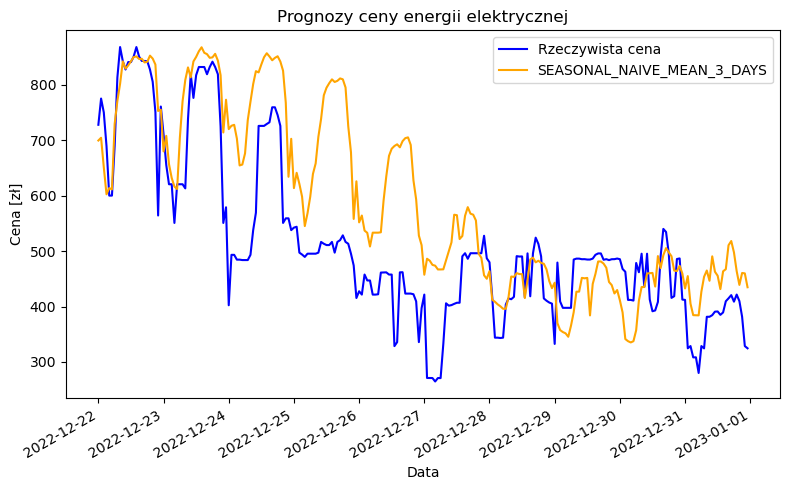

In [43]:
from sktime.utils.plotting import plot_series
from matplotlib import pyplot as plt

def plot_forecast(forecast: pd.Series, actuals: pd.Series, freq: str = "H", model: str = ""):

    plt.figure(figsize=(8, 5))
    plt.plot(actuals.resample(freq).mean(), color="blue", label="Rzeczywista cena")
    plt.plot(forecast.resample(freq).mean(), color="orange", label=model)
    plt.xticks(rotation=30, ha='right')
    
    plt.title('Prognozy ceny energii elektrycznej')
    plt.xlabel('Data')
    plt.ylabel('Cena [zł]')
    plt.tight_layout()
    plt.legend()
    
    
plot_forecast(d["SEASONAL_NAIVE_MEAN_3_DAYS"].iloc[-24*10:], d["ACTUAL"].iloc[-24*10:], freq="H", model="SEASONAL_NAIVE_MEAN_3_DAYS")